# 순환 신경망
순차 데이터를 다룰 수 있는 순환 신경망 (RNN)을 다뤄보겠음.  
하지만 RNN이 순차 데이터를 다루는 유일한 신경망은 아님.
- **작은 시퀀스일 경우** : 일반적인 밀집 네트워크 (풀리 커넥티드)
- **오디오나 텍스트처럼 매우 긴 시퀀스** : 합성곱 신경망도 실제로 잘 작동할 수 있음
- **그 사이 시퀀스** : 순환 신경망

---
## 1.1 시계열 예측하기

In [23]:
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [3]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5*np.sin((time - offset1)*(freq1*10 + 10))
    series += 0.2*np.sin((time - offset2)*(freq2*20 + 20))
    series += (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [11]:
n_steps = 50
series = generate_time_series(10000, n_steps+1)
series.shape

(10000, 51, 1)

((49, 1), (2, 1))

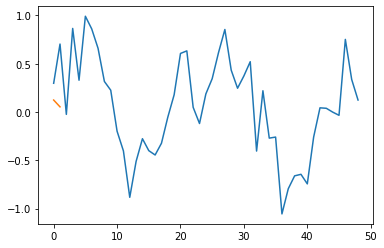

In [20]:
import matplotlib.pyplot as plt
plt.plot(series[3, :n_steps-1])
plt.plot(series[3, -3:-1])
series[3, :n_steps-1].shape, series[3, -3:-1].shape

In [21]:
X_train, y_train = series[: 7000, :n_steps], series[: 7000, -1]
X_valid, y_valid = series[7000: 9000, :n_steps], series[7000: 9000, -1]
X_test, y_test = series[9000:, n_steps], series[9000: -1]

In [24]:
base_y = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, base_y))

0.18605725

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")

In [26]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 4ms/step - loss: 0.5307 - val_loss: 0.2586
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.2378 - val_loss: 0.1844
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1757 - val_loss: 0.1491
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1476 - val_loss: 0.1322
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1300 - val_loss: 0.1248
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1249 - val_loss: 0.1218
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1209 - val_loss: 0.1206
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1193 - val_loss: 0.1202
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1194 - val_loss: 0.1199
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1162 - val_loss: 0.1199

본격적인 RNN구현에 앞서 **기준 성능**으로 삼을 모델을 구현한다.  
- **마지막 값을 그대로 출력하는 모델** : 로스 0.186
- **정말 간단한 풀리 커넥티드 신경망 모델 (플래튼 + 덴스층)** : 로스 0.12

In [27]:
rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

rnn_model.compile(loss="mse", optimizer="adam")

In [28]:
rnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 11s 48ms/step - loss: 0.2520 - val_loss: 0.2186
Epoch 2/20
219/219 [==============================] - 11s 50ms/step - loss: 0.2182 - val_loss: 0.2133
Epoch 3/20
219/219 [==============================] - 10s 48ms/step - loss: 0.2161 - val_loss: 0.2072
Epoch 4/20
219/219 [==============================] - 11s 50ms/step - loss: 0.2013 - val_loss: 0.1998
Epoch 5/20
219/219 [==============================] - 11s 48ms/step - loss: 0.1977 - val_loss: 0.1911
Epoch 6/20
219/219 [==============================] - 11s 48ms/step - loss: 0.1922 - val_loss: 0.1813
Epoch 7/20
219/219 [==============================] - 10s 47ms/step - loss: 0.1788 - val_loss: 0.1708
Epoch 8/20
219/219 [==============================] - 10s 47ms/step - loss: 0.1639 - val_loss: 0.1606
Epoch 9/20
219/219 [==============================] - 10s 48ms/step - loss: 0.1577 - val_loss: 0.1526
Epoch 10/20
219/219 [==============================] - 10s 46ms/step - loss: 0.148

In [29]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [32]:
model.summary()
print("")
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


기본 RNN의 파라미터가 3개밖에 되지 않아서인지 기본 풀리 커넥티드 모델보다 성능이 안 좋음...  
RNN을 더 추가해서 하면 좋을라나?

In [35]:
more_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

more_rnn_model.compile(loss="mse", optimizer="adam")

In [36]:
hist = more_rnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=256)

Epoch 1/20
28/28 [==============================] - 6s 171ms/step - loss: 0.6477 - val_loss: 0.2548
Epoch 2/20
28/28 [==============================] - 4s 153ms/step - loss: 0.2144 - val_loss: 0.1531
Epoch 3/20
28/28 [==============================] - 5s 161ms/step - loss: 0.1460 - val_loss: 0.1375
Epoch 4/20
28/28 [==============================] - 4s 150ms/step - loss: 0.1341 - val_loss: 0.1283
Epoch 5/20
28/28 [==============================] - 4s 153ms/step - loss: 0.1255 - val_loss: 0.1297
Epoch 6/20
28/28 [==============================] - 4s 153ms/step - loss: 0.1258 - val_loss: 0.1253
Epoch 7/20
28/28 [==============================] - 4s 153ms/step - loss: 0.1245 - val_loss: 0.1229
Epoch 8/20
28/28 [==============================] - 4s 148ms/step - loss: 0.1188 - val_loss: 0.1219
Epoch 9/20
28/28 [==============================] - 4s 143ms/step - loss: 0.1210 - val_loss: 0.1238
Epoch 10/20
28/28 [==============================] - 4s 153ms/step - loss: 0.1205 - val_loss: 0.1236

In [37]:
better_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

better_rnn_model.compile(loss="mse", optimizer="adam")

In [38]:
hist = better_rnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=256)

Epoch 1/20
28/28 [==============================] - 4s 105ms/step - loss: 0.5543 - val_loss: 0.1527
Epoch 2/20
28/28 [==============================] - 3s 98ms/step - loss: 0.1417 - val_loss: 0.1307
Epoch 3/20
28/28 [==============================] - 3s 107ms/step - loss: 0.1281 - val_loss: 0.1244
Epoch 4/20
28/28 [==============================] - 3s 94ms/step - loss: 0.1224 - val_loss: 0.1227
Epoch 5/20
28/28 [==============================] - 3s 99ms/step - loss: 0.1202 - val_loss: 0.1214
Epoch 6/20
28/28 [==============================] - 3s 106ms/step - loss: 0.1225 - val_loss: 0.1201
Epoch 7/20
28/28 [==============================] - 3s 99ms/step - loss: 0.1185 - val_loss: 0.1199
Epoch 8/20
28/28 [==============================] - 3s 101ms/step - loss: 0.1205 - val_loss: 0.1185
Epoch 9/20
28/28 [==============================] - 3s 107ms/step - loss: 0.1191 - val_loss: 0.1195
Epoch 10/20
28/28 [==============================] - 3s 107ms/step - loss: 0.1185 - val_loss: 0.1194
Epo

---
## n 스텝 후 예측모델 만들기

위에서는 바로 다음 타임 스텝의 값만 예측했지만 타깃을 적절히 바꾸어 여러 다임 스텝 앞의 값을 예측할 수도 있음.
1. 이미 학습된 모델을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가하여 그 다음값을 예측하는 방식
2. RNN을 학습하여 다음 값 10개를 한 번에 예측하는 방식

물론 우리는 2번째 방법을 사용할 것

In [74]:
series = generate_time_series(10000, n_steps+10)
X_train, Y_train = series[: 7000, :n_steps], series[: 7000, -10:, 0]
X_valid, Y_valid = series[7000: 9000, :n_steps], series[7000: 9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [48]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.005))

In [50]:
model.fit(X_train, Y_train, epochs=20, batch_size=256, validation_data=(X_valid, Y_valid))

Epoch 1/20
28/28 [==============================] - 4s 111ms/step - loss: 0.2826 - val_loss: 0.1518
Epoch 2/20
28/28 [==============================] - 3s 103ms/step - loss: 0.1493 - val_loss: 0.1457
Epoch 3/20
28/28 [==============================] - 3s 105ms/step - loss: 0.1444 - val_loss: 0.1434
Epoch 4/20
28/28 [==============================] - 3s 98ms/step - loss: 0.1406 - val_loss: 0.1383
Epoch 5/20
28/28 [==============================] - 3s 109ms/step - loss: 0.1363 - val_loss: 0.1404
Epoch 6/20
28/28 [==============================] - 3s 105ms/step - loss: 0.1345 - val_loss: 0.1351
Epoch 7/20
28/28 [==============================] - 3s 101ms/step - loss: 0.1326 - val_loss: 0.1261
Epoch 8/20
28/28 [==============================] - 3s 101ms/step - loss: 0.1257 - val_loss: 0.1292
Epoch 9/20
28/28 [==============================] - 3s 104ms/step - loss: 0.1271 - val_loss: 0.1233
Epoch 10/20
28/28 [==============================] - 3s 101ms/step - loss: 0.1242 - val_loss: 0.1237


In [54]:
Y_pred = model.predict(X_test[:1])
Y_pred, Y_test[0]

(array([[-0.420305  , -0.42009377, -0.47151214, -0.40927234, -0.3863176 ,
         -0.4372608 , -0.36537632, -0.24576448, -0.24907728, -0.09821991]],
       dtype=float32),
 array([-0.8713608 , -0.13092701, -0.7272108 , -0.17893595, -0.71002346,
        -0.53033584, -0.10122246, -0.37610924, -0.45661607, -0.32351223],
       dtype=float32))

?? 일단 성능은 별로 안 좋은 것 같음.  
이 모델은 개선의 여지가 있다고 함.  
---
마지막 스텝에서만 다음 값 10개를 예측하도록 모델을 학습하는 대신
>- 모든 타임 스텝에서 다음 값 10개를 예측하도록 모델을 학습할 수 있음. 시퀀스-투-벡터를 시퀀스-투-시퀀스로
>- 이 방식의 장점은 마지막 타임 스텝에서의 출력뿐만 아니라 모든 타임 스텝에서 RNN출력에 대한 항이 손실에 포함된다는 것. 즉 더 많은 오차 그레디언트가 모델로 흐른다는 뜻. 이는 학습을 안정적으로 만들고 학습 속도를 높여줌.

In [76]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10+1):
    Y[:, :, step_ahead-1] = series[:, step_ahead:step_ahead+n_steps, 0]

Y_train = Y[: 7000]
Y_valid = Y[7000: 9000]
Y_test = Y[9000: ]

> X_train과 Y_train은 중복이 많음. 잘못 학습하는 것이 아닌가?  
다행히 아니라고 함. 타입 스텝마다 모델은 이전 타임 스텝만 볼 수 있고 앞을 볼 수는 없음.  
이를 **인과 모델** 이라고 함

In [77]:
better_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

이 모델을 시퀀스-투-시퀀스 모델로 바꾸려면 모든 순환층에(마지막 층도) **return_sequences**를 True로 지정해야 함.  
그 다음 모든 타입 스텝에서 출력을 Dense층에 적용해야 함. 이를 **TimeDistributed** 층으로 해결.  
> 이 층은 다른 층을 감싸서 **입력 시퀀스의 모든 타임 스텝에 이를 적용함**.  
각 타임 스텝을 별개의 샘플처럼 다루도록 입력의 크기를 바꾸어 이를 효과적으로 수행함.  
즉 **[배치 크기, 타임 스텝 수, 차원 수]를 [배치 크기 * 타임 스텝 수, 차원 수]로 바꿈**(?)

이 모델은 학습하는 데는 모든 출력이 필요하지만 예측과 평가에서는 마지막 타임 스텝의 출력만 사용됨.  
학습을 위해 모든 출력에 걸쳐 MSE를 계산하고, 평가를 위해서는 마지막 타임 스텝의 출력에 대한 MSE만을 계산하는 사용자 정의 지표를 만들어야 함

In [80]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

better_model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=[last_time_step_mse])

In [81]:
better_model.fit(X_train, Y_train, epochs=20, batch_size=256, validation_data=(X_valid, Y_valid))

Epoch 1/20
28/28 [==============================] - 4s 121ms/step - loss: 0.2673 - last_time_step_mse: 0.2666 - val_loss: 0.1552 - val_last_time_step_mse: 0.1480
Epoch 2/20
28/28 [==============================] - 3s 108ms/step - loss: 0.1521 - last_time_step_mse: 0.1442 - val_loss: 0.1499 - val_last_time_step_mse: 0.1419
Epoch 3/20
28/28 [==============================] - 3s 103ms/step - loss: 0.1494 - last_time_step_mse: 0.1424 - val_loss: 0.1483 - val_last_time_step_mse: 0.1408
Epoch 4/20
28/28 [==============================] - 3s 102ms/step - loss: 0.1479 - last_time_step_mse: 0.1394 - val_loss: 0.1464 - val_last_time_step_mse: 0.1377
Epoch 5/20
28/28 [==============================] - 3s 100ms/step - loss: 0.1459 - last_time_step_mse: 0.1361 - val_loss: 0.1491 - val_last_time_step_mse: 0.1445
Epoch 6/20
28/28 [==============================] - 3s 102ms/step - loss: 0.1455 - last_time_step_mse: 0.1363 - val_loss: 0.1449 - val_last_time_step_mse: 0.1342
Epoch 7/20
28/28 [==========

In [69]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))